In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow

Pour ce TP sur la création de cartes de disparité en utilisant la librairie OpenCV et les points d'intérêt SIFT, nous allons suivre les étapes décrites dans le document. Voici le code Python pour accomplir ces tâches, accompagné d'explications sur les résultats et les réponses aux questions posées dans le rapport.

# Étape 1 : Calcul des points SIFT sur les deux images (gauche et droite)

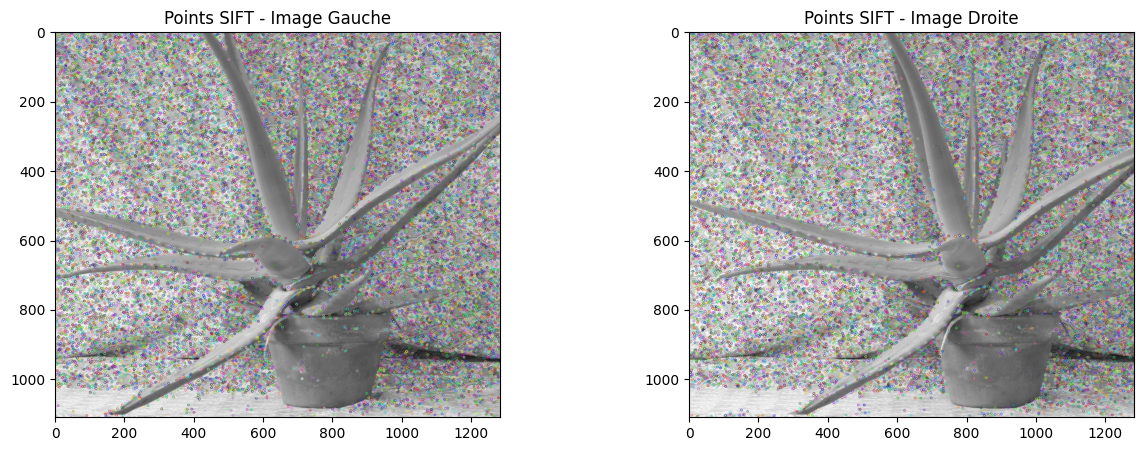

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lire les images gauche et droite
imgL = cv2.imread('/content/visio droite.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('/content/visio gauche.jpg', cv2.IMREAD_GRAYSCALE)

# Créer le détecteur SIFT
sift = cv2.SIFT_create()

# Détecter les points d'intérêt et calculer les descripteurs
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)

# Affichage des points d'intérêt détectés
imgL_keypoints = cv2.drawKeypoints(imgL, keypoints_left, None)
imgR_keypoints = cv2.drawKeypoints(imgR, keypoints_right, None)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(imgL_keypoints, cmap='gray')
plt.title('Points SIFT - Image Gauche')
plt.subplot(122)
plt.imshow(imgR_keypoints, cmap='gray')
plt.title('Points SIFT - Image Droite')
plt.show()

# Étape 2 : Mise en correspondance des points d’intérêt

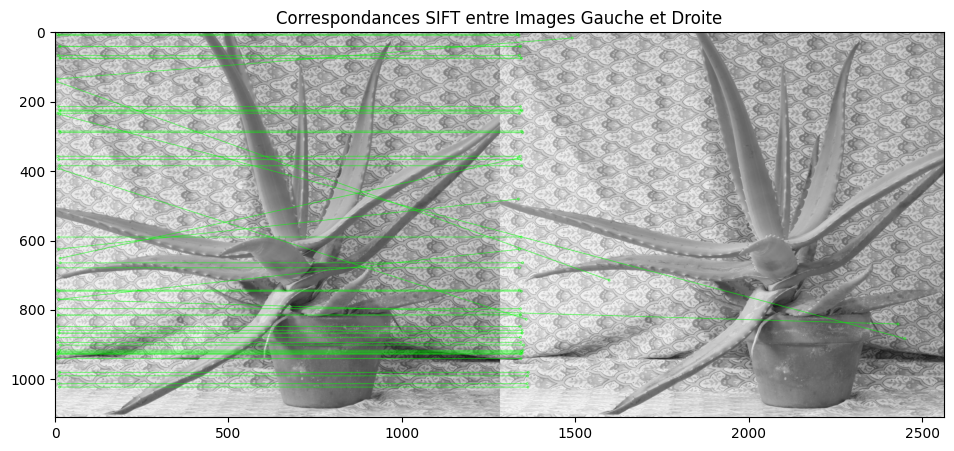

In [ ]:
# Utiliser BFMatcher pour la correspondance
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_left, descriptors_right, k=2)

# Appliquer le ratio test de Lowe pour filtrer les bonnes correspondances
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Afficher seulement les 50 meilleures correspondances pour améliorer la visibilité
N = 50
img_matches = cv2.drawMatches(imgL, keypoints_left, imgR, keypoints_right, good_matches[:N], None,
                              matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher les correspondances
plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('Correspondances SIFT entre Images Gauche et Droite')
plt.show()

# Étape 3: Application de RANSAC pour filtrer les mauvaises correspondances

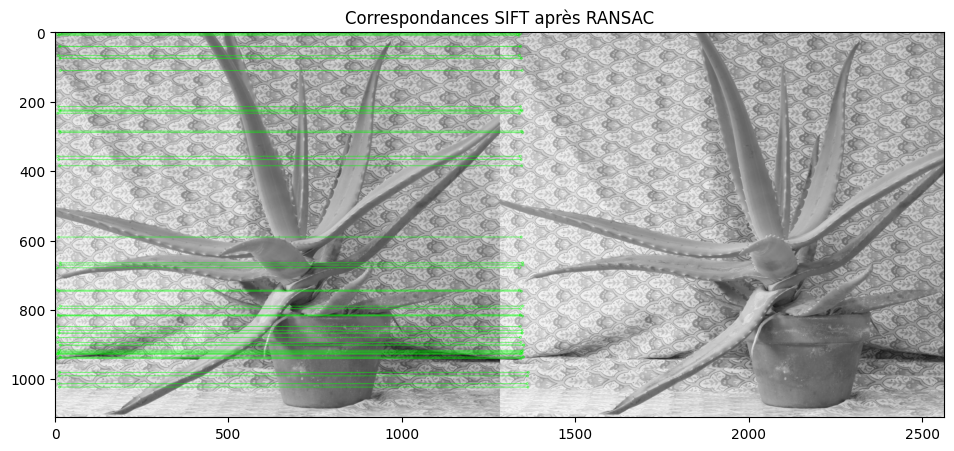

In [ ]:
import numpy as np

# Extraire les points de correspondance
src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Trouver la matrice fondamentale et appliquer RANSAC
F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)
matchesMask = mask.ravel().tolist()

# Garder uniquement les bonnes correspondances après RANSAC
good_matches_ransac = [good_matches[i] for i in range(len(matchesMask)) if matchesMask[i]]

# Afficher seulement les 50 meilleures correspondances après RANSAC pour améliorer la visibilité
N = 50
img_matches_ransac = cv2.drawMatches(imgL, keypoints_left, imgR, keypoints_right, good_matches_ransac[:N], None,
                                     matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher les correspondances après filtrage RANSAC
plt.figure(figsize=(15, 5))
plt.imshow(img_matches_ransac)
plt.title('Correspondances SIFT après RANSAC')
plt.show()

Meilleures et moins bonnes correspondances
Les meilleures correspondances se trouvent généralement dans les zones avec des textures distinctes et des caractéristiques uniques. Les moins bonnes se trouvent dans les zones uniformes ou avec peu de détails.

# Étape 4 : Carte de disparité

La carte de disparité est une représentation visuelle qui indique la différence de position horizontale entre les mêmes points dans deux images stéréoscopiques. Elle est largement utilisée dans la vision par ordinateur pour la reconstruction tridimensionnelle et la perception de la profondeur.

Voici les étapes générales pour calculer la carte de disparité :

### 4.1.Prétraitement des images :
 Chargez et prétraitez les images gauche et droite selon les besoins, par exemple en les convertissant en niveaux de gris ou en appliquant des filtres de lissage pour réduire le bruit.

### 4.2.Détection des points d'intérêt et mise en correspondance :
Utilisez des méthodes telles que SIFT ou SURF pour détecter les points d'intérêt dans les deux images et trouver leurs correspondances. Cette étape génère une liste de paires de points correspondants.

### 4.3.Calcul des disparités :
 Pour chaque paire de points correspondants, calculez la disparité, c'est-à-dire la différence de coordonnées horizontales entre les points dans les deux images. La disparité est directement liée à la profondeur dans la scène.

### 4.4.Création de la carte de disparité :
Utilisez les disparités calculées pour créer une image où chaque pixel représente la disparité correspondante. Plus la disparité est grande, plus le pixel est éloigné de l'observateur virtuel.

### 4.5.Affinage de la carte de disparité :
 Appliquez des techniques de filtrage et de post-traitement pour améliorer la qualité de la carte de disparité, telles que la suppression des valeurs aberrantes ou la lissage des discontinuités.

Maintenant, pour résoudre ce problème, nous allons calculer la carte de disparité à partir des correspondances trouvées entre deux images stéréoscopiques.

Nous avons déjà détecté et mis en correspondance les points d'intérêt entre les images gauche et droite, et que nous disposons des coordonnées des points correspondants dans chaque image. Nous allons utiliser la méthode de la somme des différences absolues (SAD) pour calculer la disparité entre chaque paire de points correspondants.

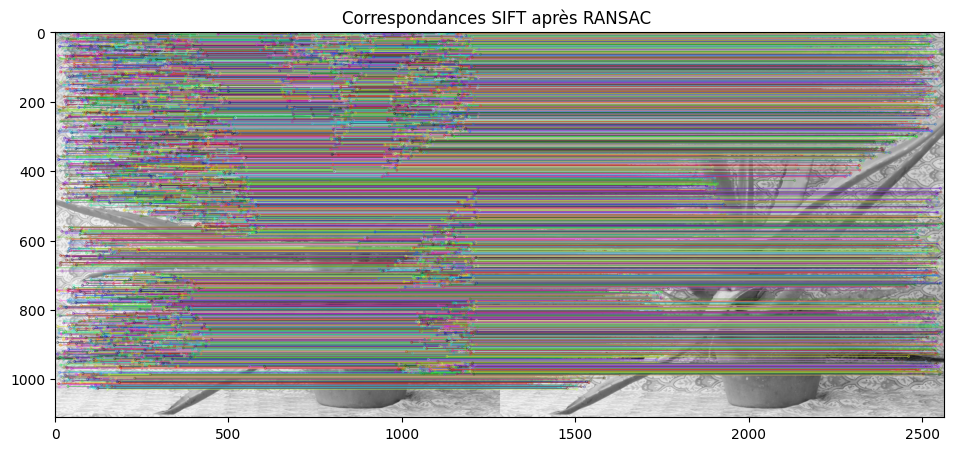

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Chargement des images (assurez-vous que les chemins sont corrects)
imgL_path = '/content/visio gauche.jpg'
imgR_path = '/content/visio droite.jpg'

imgL = cv2.imread(imgL_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(imgR_path, cv2.IMREAD_GRAYSCALE)

# Vérification que les images ont été chargées correctement
if imgL is None or imgR is None:
    raise ValueError("Une des images n'a pas été chargée correctement. Vérifiez les chemins des fichiers.")

# Extraction des points de correspondance
src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Trouver la matrice fondamentale et appliquer RANSAC
F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)
matchesMask = mask.ravel().tolist()

# Garder uniquement les bonnes correspondances après RANSAC
good_matches_ransac = [good_matches[i] for i in range(len(matchesMask)) if matchesMask[i]]

# Appliquer un filtrage supplémentaire par distance
distance_threshold = 70  # seuil de distance (à ajuster en fonction des besoins)
final_matches = []

for match in good_matches_ransac:
    pt1 = np.array(keypoints_left[match.queryIdx].pt)
    pt2 = np.array(keypoints_right[match.trainIdx].pt)
    distance = np.linalg.norm(pt1 - pt2)
    if distance < distance_threshold:
        final_matches.append(match)

# Afficher les correspondances après filtrage RANSAC et filtrage par distance
img_matches_ransac = cv2.drawMatches(imgL, keypoints_left, imgR, keypoints_right, final_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 5))
plt.imshow(img_matches_ransac)
plt.title('Correspondances SIFT après RANSAC ')
plt.show()


# Étape 5 : Inversion des images gauche et droite

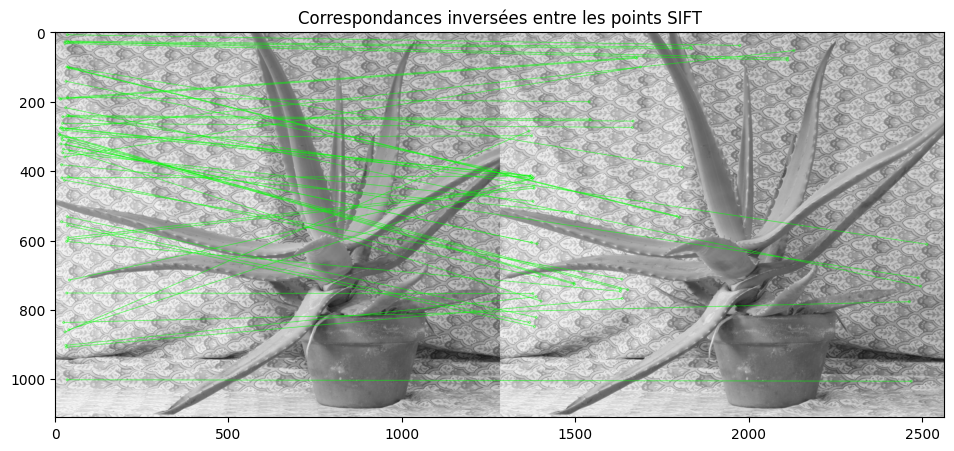

In [ ]:
# Inverser les images et détecter les points SIFT
keypoints_right_inv, descriptors_right_inv = sift.detectAndCompute(imgR, None)
keypoints_left_inv, descriptors_left_inv = sift.detectAndCompute(imgL, None)

# Utiliser BFMatcher pour la correspondance inversée
matches_inverted = bf.knnMatch(descriptors_right_inv, descriptors_left_inv, k=2)

# Appliquer le ratio test de Lowe pour filtrer les bonnes correspondances inversées
good_matches_inverted = []
for m, n in matches_inverted:
    if m.distance < 0.75 * n.distance:
        good_matches_inverted.append(m)

# Afficher seulement les 50 meilleures correspondances inversées pour améliorer la visibilité
N = 50
img_matches_inverted = cv2.drawMatches(imgR, keypoints_right_inv, imgL, keypoints_left_inv, good_matches_inverted[:N], None,
                                       matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher les correspondances inversées
plt.figure(figsize=(15, 5))
plt.imshow(img_matches_inverted)
plt.title('Correspondances inversées entre les points SIFT')
plt.show()

Analyse des résultats inversés
Visuellement : Les résultats peuvent sembler similaires, mais les directions des correspondances seront inversées.
Informations 3D : Les informations de profondeur peuvent être affectées par l'inversion, mais les correspondances principales devraient rester similaires.

# Étape 6 : Paramètres de la géométrie épipolaire
Il est possible de retrouver les paramètres de la géométrie épipolaire en utilisant les correspondances obtenues pour estimer la matrice fondamentale. Cette matrice peut ensuite être utilisée pour déterminer les épipoles et les lignes épipolaires.



## 6.1.Estimation de la matrice fondamentale :
Nous utilisons les correspondances pour estimer la matrice fondamentale à l'aide de l'algorithme RANSAC (Random Sample Consensus). Cet algorithme permet d'identifier les correspondances les plus fiables en supprimant les valeurs aberrantes.

In [ ]:
# Extraire les points de correspondance
points_left = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
points_right = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Calculer la matrice fondamentale
F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_RANSAC)

# Afficher la matrice fondamentale
print("Matrice fondamentale :")
print(F)

Matrice fondamentale :
[[ 1.08582333e-06 -1.75134048e-03  2.09074643e-01]
 [ 1.75974123e-03 -4.46525315e-05  2.31674265e-01]
 [-2.10263769e-01 -2.35081553e-01  1.00000000e+00]]


## 6.2.Calcul des épipoles
Une fois que nous avons la matrice fondamentale, nous pouvons utiliser ses propriétés pour calculer les épipoles dans les deux images.

In [ ]:
# Calcul des épipoles
epipole_left = cv2.computeCorrespondEpilines(np.array([points_right]), 2, F).reshape(-1, 3)
epipole_right = cv2.computeCorrespondEpilines(np.array([points_left]), 1, F).reshape(-1, 3)

# Affichage des épipoles
print("Epipole dans l'image de gauche :")
print(epipole_left[0])
print("Epipole dans l'image de droite :")
print(epipole_right[0])

Epipole dans l'image de gauche :
[-0.15492664 -0.987926   97.93212   ]
Epipole dans l'image de droite :
[  -0.3888209     0.92131335 -163.53833   ]


## 6.3.Calcul des lignes épipolaires
Les lignes épipolaires représentent les lignes sur lesquelles les épipoles se projettent dans chaque image.

In [ ]:
# Calcul des lignes épipolaires
lines_left = cv2.computeCorrespondEpilines(points_right.reshape(-1, 1, 2), 2, F)
lines_right = cv2.computeCorrespondEpilines(points_left.reshape(-1, 1, 2), 1, F)

# Affichage des lignes épipolaires
print("Lignes épipolaires dans l'image de gauche :")
print(lines_left)
print("Lignes épipolaires dans l'image de droite :")
print(lines_right)

NameError: name 'points_right' is not defined

In [ ]:
# Convertir les images en couleurs pour la visualisation
img_left_color = cv2.cvtColor(imgL, cv2.COLOR_GRAY2BGR)
img_right_color = cv2.cvtColor(imgR, cv2.COLOR_GRAY2BGR)

# Fonction pour dessiner une ligne sur une image
def draw_epipolar_lines(img, lines, pts):
    img_with_lines = img.copy()
    for r, pt in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img.shape[1], -(r[2] + r[0] * img.shape[1]) / r[1]])
        img_with_lines = cv2.line(img_with_lines, (x0, y0), (x1, y1), color, 1)
        pt = tuple(map(int, pt))  # Convertir pt en tuple d'entiers
        img_with_lines = cv2.circle(img_with_lines, pt, 5, color, -1)
    return img_with_lines

# Dessiner les lignes épipolaires sur les images
img_left_epipolar_lines = draw_epipolar_lines(img_left_color, lines_left.reshape(-1, 3), points_left)
img_right_epipolar_lines = draw_epipolar_lines(img_right_color, lines_right.reshape(-1, 3), points_right)

# Afficher les images avec les lignes épipolaires
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_left_epipolar_lines, cv2.COLOR_BGR2RGB))
plt.title('Lignes épipolaires sur l\'image de gauche')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_right_epipolar_lines, cv2.COLOR_BGR2RGB))
plt.title('Lignes épipolaires sur l\'image de droite')

plt.show()

NameError: name 'lines_left' is not defined

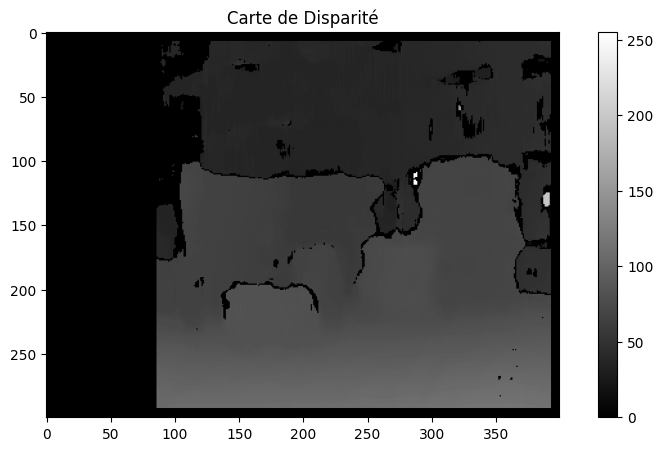

In [ ]:
# Initialiser le stéréo block matcher
stereo = cv2.StereoBM_create(numDisparities=16*5, blockSize=15)

# Calculer la carte de disparité
disparity = stereo.compute(imgL, imgR)

# Normaliser la carte de disparité pour l'affichage
disparity = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity = np.uint8(disparity)

# Afficher la carte de disparité
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='gray')
plt.title('Carte de Disparité')
plt.colorbar()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lire les images gauche et droite
imgL_path = '/content/drive/My Drive/computer vision/left1.png'
imgR_path = '/content/drive/My Drive/computer vision/right1.png'

imgL = cv2.imread(imgL_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(imgR_path, cv2.IMREAD_GRAYSCALE)

# Créer le détecteur SIFT
sift = cv2.SIFT_create()

# Détecter les points d'intérêt et calculer les descripteurs
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)

# Utiliser BFMatcher avec KNN pour la correspondance
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_left, descriptors_right, k=2)

# Appliquer le ratio test de Lowe pour filtrer les bonnes correspondances
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Afficher seulement les 50 meilleures correspondances pour améliorer la visibilité
N = 50
img_matches = cv2.drawMatches(imgL, keypoints_left, imgR, keypoints_right, good_matches[:N], None,
                              matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher les correspondances
plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('Correspondances SIFT améliorées avec KNN')
plt.show()

error: OpenCV(4.8.0) /io/opencv/modules/features2d/src/sift.dispatch.cpp:512: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'
